**Summary for EDA**
- Bank Customers related attributes
1. <font color='blue'>age: numerical; we label this numerical data into 3 catagorical groups (‘age_bin’) and do OneHotEncoder/Dummy transform.</font>
2. <font color='blue'>job: categorical; we drop “unknown” level and do Dummy transform. </font>
3. <font color='orange'>marital: categorical; we add “unknown” into 'married' level and do Ordinal transform.</font>
4. <font color='orange'>education: categorical; we add the “unknown” level to “university.degree” level, do OrdinalEncoder transformation.</font>
5. <font color='red'>default: categorical; remove.</font>
6. <font color='red'>housing: categorical; remove.</font>
7. <font color='red'>loan: categorical; remove.</font>
- Marketting Campaigns related attributes
1. <font color='red'>duration: numerical; remove.</font>
2. campaign: numerical; keep.
3. <font color='blue'>pdays: numerical; we label this numerical data into 6 catagorical groups (‘pdays_bin’) and do OneHotEncoder/Dummy transform</font>
4. previous: numerical; keep.
5. <font color='blue'>contact: categorical; we use dummy transform it to numerical data.</font>
6. <font color='blue'>month: categorical; we use dummy to transform this variable into numerical data.</font>
7. <font color='blue'>day_of_week: categorical; we use dummy to transform this variable into numerical data.</font>
8. <font color='blue'>poutcome: categorical; we use dummy to transform this variable into numerical data.</font>
- Social and economic context attributes summary
1. <font color='red'>emp_var_rate: numerical; remove.</font>
2. cons.price.idx: numerical; keep. 
3. cons.conf.idx: numerical; keep. 
4. euribor3m: numerical; keep.
5. nr.employed: numerical; keep.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style = 'whitegrid')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer,classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.base import TransformerMixin
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from mlxtend.evaluate import confusion_matrix

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import VotingClassifier
from mlxtend.plotting import plot_decision_regions 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.model_selection import StratifiedKFold
import shap

# Data Preparation

In [3]:
#import data
df = pd.read_csv('200_bank-additional-full.csv', sep=';')
df.shape

(41188, 21)

In [4]:
df.duplicated().sum()

12

In [5]:
df = df.drop_duplicates()
df.shape

(41176, 21)

In [6]:
#rename some of the columns
df.columns = df.columns.str.replace('.','_')
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [7]:
# change admin. in job
df['job']=df.job.apply(lambda x: x.strip('. '))

In [8]:
# delete 6 rows (removing outliers) and 5 columns
df.drop(columns=['duration','loan','housing','default'],
        inplace=True)
df.shape

(41176, 17)

In [9]:
df.shape

(41176, 17)

In [10]:
data = {'Column': [41188,41176], 'Feature': [21,17]}
pd.DataFrame(data, index = ['Original Dataset', 'Cleaned Dataset'])

,Column,Feature
Original Dataset,41188,21
Cleaned Dataset,41176,17


In [11]:
# pdays bin
df['pdays'] = pd.cut(df['pdays'], [0, 6, 13,  20, 30, 999], 
                       labels=['0-6', '6-13', '13-20', '20-27','-1'])

In [12]:
#age bin
df['age'] = pd.cut(df['age'], [0, 21, 60, 100], 
                       labels=['0-21', '21-60', '60-100'])

### Target

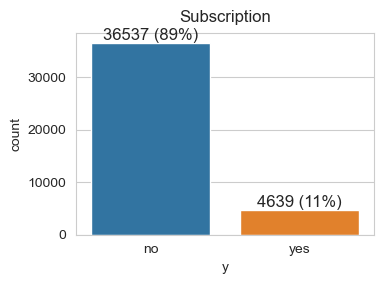

In [13]:
# target frequency plot
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x=df['y'], ax=ax)
sns.set_theme(style="whitegrid")

abs_vals = df['y'].value_counts()
rel_vals = df['y'].value_counts(normalize=True) * 100
labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_vals, rel_vals)]

ax.bar_label(container=ax.containers[0], labels=labels)
ax.set_title('Subscription', fontsize=12, pad=8)

plt.tight_layout();

In [14]:
data = {'Unsubscribed': [36537,89], 'Subscribed': [4639,11]}
pd.DataFrame(data, index = ['Count', '%'])

,Unsubscribed,Subscribed
Count,36537,4639
%,89,11


In [15]:
# target labbelEncoding
df['y'] = LabelEncoder().fit_transform(df['y'])
df.head(2)

,age,job,marital,education,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,21-60,housemaid,married,basic.4y,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,21-60,services,married,high.school,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


### Train test data split

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2, stratify=df.y, shuffle=True,random_state = 2023)

In [17]:
train.shape

(32940, 17)

In [18]:
test.shape

(8236, 17)

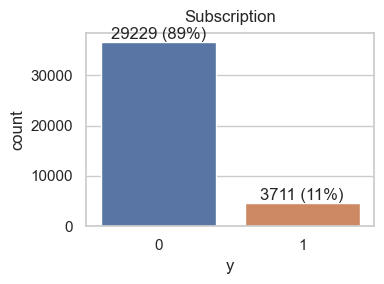

In [19]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x=df['y'], ax=ax)
sns.set_theme(style="whitegrid")

abs_vals = train['y'].value_counts()
rel_vals = train['y'].value_counts(normalize=True) * 100
labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_vals, rel_vals)]

ax.bar_label(container=ax.containers[0], labels=labels)
ax.set_title('Subscription', fontsize=12, pad=8)

plt.tight_layout();

In [20]:
data = {'Unsubscribed': [29229,89], 'Subscribed': [3711,11]}
pd.DataFrame(data, index = ['Count', '%'])

,Unsubscribed,Subscribed
Count,29229,3711
%,89,11


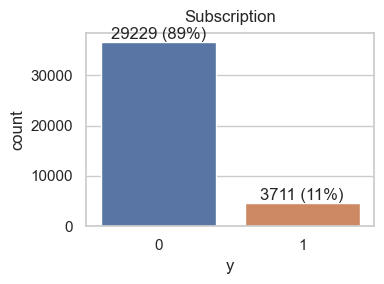

In [21]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x=df['y'], ax=ax)
sns.set_theme(style="whitegrid")

abs_vals = train['y'].value_counts()
rel_vals = train['y'].value_counts(normalize=True) * 100
labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_vals, rel_vals)]

ax.bar_label(container=ax.containers[0], labels=labels)
ax.set_title('Subscription', fontsize=12, pad=8)

plt.tight_layout();

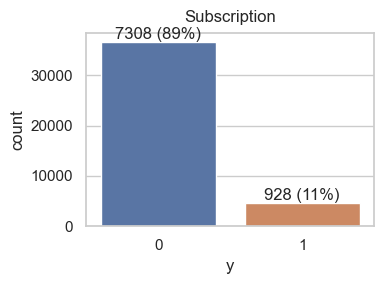

In [22]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x=df['y'], ax=ax)
sns.set_theme(style="whitegrid")

abs_vals = test['y'].value_counts()
rel_vals = test['y'].value_counts(normalize=True) * 100
labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_vals, rel_vals)]

ax.bar_label(container=ax.containers[0], labels=labels)
ax.set_title('Subscription', fontsize=12, pad=8)

plt.tight_layout();

In [23]:
data = {'Unsubscribed': [7308,89], 'Subscribed': [928,11]}
pd.DataFrame(data, index = ['Count', '%'])

,Unsubscribed,Subscribed
Count,7308,928
%,89,11


In [24]:
features = list(train.columns)
target = 'y'
features.remove(target)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [25]:
X_train

,age,job,marital,education,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
28767,21-60,services,single,basic.9y,cellular,apr,thu,2,-1,0,nonexistent,-1.8,93.075,-47.1,1.410,5099.1
8196,21-60,blue-collar,single,high.school,telephone,jun,tue,3,-1,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
40596,21-60,admin,single,university.degree,cellular,sep,thu,2,6-13,3,success,-1.1,94.199,-37.5,0.884,4963.6
21614,21-60,technician,married,high.school,cellular,aug,tue,1,-1,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
32092,21-60,services,single,high.school,cellular,may,fri,2,-1,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14300,21-60,management,married,university.degree,cellular,jul,mon,3,-1,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
17974,21-60,admin,single,high.school,cellular,jul,tue,8,-1,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1
4557,21-60,blue-collar,married,basic.4y,telephone,may,tue,4,-1,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0
3846,21-60,management,married,university.degree,telephone,may,fri,10,-1,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0


### Pipeline

In [26]:
class ordinal_Transformer(TransformerMixin):

    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['education'] = X['education'].replace("unknown", "university.degree", inplace=True)
        df['marital'] = X['marital'].replace("unknown", "married", inplace=True)
        self.ord1 = {"illiterate":0, "basic.4y":1, "basic.6y":1, "basic.9y":1,"high.school":2,
                    "professional.course":3,"university.degree":4}
        self.ord2 = {"married":0,"single":2,"divorced":1}
      

    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['education'] = X['education'].replace("unknown", "university.degree", inplace=True)
        df['marital'] = X['marital'].replace("unknown", "single", inplace=True)
        df['education'] = X['education'].map(self.ord1)
        df['marital'] = X['marital'].map(self.ord2)
        return df

    def fit_transform(self, X, y=None):     
        self.fit(X)
        return self.transform(X)

In [27]:
df.columns

Index(['age', 'job', 'marital', 'education', 'contact', 'month', 'day_of_week',
       'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [28]:
cat_features_1 = ["age","job", "pdays", "contact", "month", "day_of_week", "poutcome"]
num_features = ["campaign", "previous", "cons_price_idx", "cons_conf_idx","euribor3m", "nr_employed",'emp_var_rate']
ordinal_features = ['education', 'marital']

In [29]:
num_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

onehot_transformer = Pipeline(steps=[("onehot", OneHotEncoder())])

ord_transformer = Pipeline(steps=[('ord',ordinal_Transformer())])

preprocessor = ColumnTransformer(
               [('num', num_transformer,num_features),
                ('ordinal', ord_transformer,ordinal_features),
                ('cat', onehot_transformer,cat_features_1)
               ])

In [30]:
from sklearn import set_config
set_config(display="diagram")
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['campaign', 'previous', 'cons_price_idx',
                                  'cons_conf_idx', 'euribor3m', 'nr_employed',
                                  'emp_var_rate']),
                                ('ordinal',
                                 Pipeline(steps=[('ord',
                                                  <__main__.ordinal_Transformer object at 0x7fc983937520>)]),
                                 ['education', 'marital']),
                                ('cat',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 ['age', 'job', 'pdays', 'contact', 'month',
                                  'day_of_week', 'poutcome'])])

In [31]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['campaign', 'previous', 'cons_price_idx',
                                  'cons_conf_idx', 'euribor3m', 'nr_employed',
                                  'emp_var_rate']),
                                ('ordinal',
                                 Pipeline(steps=[('ord',
                                                  <__main__.ordinal_Transformer object at 0x7fc983937520>)]),
                                 ['education', 'marital']),
                                ('cat',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 ['age', 'job', 'pdays', 'contact', 'month',
                                  'day_of_week', 'poutcome'])])

In [32]:
onehot_cols = (preprocessor.named_transformers_["cat"]
                           .named_steps["onehot"]
                           .get_feature_names_out(cat_features_1)
               )
onehot_cols

array(['age_0-21', 'age_21-60', 'age_60-100', 'job_admin',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'pdays_-1', 'pdays_0-6', 'pdays_13-20',
       'pdays_20-27', 'pdays_6-13', 'pdays_nan', 'contact_cellular',
       'contact_telephone', 'month_apr', 'month_aug', 'month_dec',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success'],
      dtype=object)

In [33]:
columns = num_features + ordinal_features + onehot_cols.tolist()
X_train_pp = preprocessor.fit_transform(X_train)
print(columns)
new = pd.DataFrame(X_train_pp, columns=columns)
new

['campaign', 'previous', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'emp_var_rate', 'education', 'marital', 'age_0-21', 'age_21-60', 'age_60-100', 'job_admin', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'pdays_-1', 'pdays_0-6', 'pdays_13-20', 'pdays_20-27', 'pdays_6-13', 'pdays_nan', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success']


,campaign,previous,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,emp_var_rate,education,marital,age_0-21,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.018182,0.0,0.340608,0.154812,0.175924,0.512287,0.333333,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.036364,0.0,0.882307,0.376569,0.958966,1.000000,1.000000,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.018182,0.5,0.778644,0.556485,0.056676,0.000000,0.479167,4.0,2.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,0.0,0.484412,0.615063,0.981410,1.000000,1.000000,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.018182,0.0,0.269680,0.192469,0.153933,0.512287,0.333333,2.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32935,0.036364,0.0,0.669135,0.338912,0.981183,1.000000,1.000000,4.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
32936,0.127273,0.0,0.669135,0.338912,0.980957,1.000000,1.000000,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
32937,0.054545,0.0,0.698753,0.602510,0.957153,0.859735,0.937500,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
32938,0.163636,0.0,0.698753,0.602510,0.957833,0.859735,0.937500,4.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## logistic regression

### imbalanced data

In [34]:
model_lgr = Pipeline(steps=
                     [('preprocessor', preprocessor),
                     ('scaler', MinMaxScaler()),
                      ('lgr', LogisticRegression())
                      ]
                      )
model_lgr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fc983937520>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('scaler', MinMaxScaler()), ('lgr', LogisticRegression())])

In [162]:
#set_config(display="diagram")
#model_lgr

In [163]:
y_train_pred = model_lgr.predict(X_train)
y_test_pred = model_lgr.predict(X_test)

In [164]:
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     29229
           1       0.66      0.23      0.34      3711

    accuracy                           0.90     32940
   macro avg       0.79      0.61      0.64     32940
weighted avg       0.88      0.90      0.88     32940

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7308
           1       0.69      0.22      0.34       928

    accuracy                           0.90      8236
   macro avg       0.80      0.60      0.64      8236
weighted avg       0.88      0.90      0.88      8236



In [165]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, model_lgr.predict_proba(X_train)[:, 1])), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, model_lgr.predict_proba(X_test)[:, 1])))

Train roc auc score:  0.792 
Test roc auc score 0.801


In [166]:
#evaluate_model(model_lgr, X_train, y_train_pred)

### balanced data

In [167]:
model_lgr2 = Pipeline(steps=
                     [('preprocessor', preprocessor),
                      ('lgr', LogisticRegression(class_weight = 'balanced',fit_intercept=False)
                      )]
                    )
model_lgr2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fdd6c94ac40>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('lgr',
                 LogisticRegression(class_weight='balanced',
                                    fit_intercept=False))])

In [168]:
model_lgr2 = Pipeline(steps=
                     [('preprocessor', preprocessor),
                      ('lgrCV',LogisticRegressionCV(cv = 3, penalty='l2', solver = 'saga', max_iter=100000, scoring='recall', n_jobs = -1)
                      )]
                    )


In [169]:
model_lgr2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fdd6c94ac40>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('lgrCV',
                 LogisticRegressionCV(cv=3, max_iter=100000, n_jobs=-1,
                                      scoring='recall', solver='saga'))])

In [170]:
y_train_pred2 = model_lgr2.predict(X_train)
y_test_pred2 = model_lgr2.predict(X_test)

In [171]:
#evaluate_model(model_lgr2, X_train, y_train)

In [172]:
print(classification_report(y_train, y_train_pred2))
print(classification_report(y_test, y_test_pred2))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     29229
           1       0.66      0.23      0.34      3711

    accuracy                           0.90     32940
   macro avg       0.78      0.61      0.65     32940
weighted avg       0.88      0.90      0.88     32940

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7308
           1       0.69      0.22      0.34       928

    accuracy                           0.90      8236
   macro avg       0.80      0.61      0.64      8236
weighted avg       0.88      0.90      0.88      8236



In [173]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, model_lgr2.predict_proba(X_train)[:, 1])), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, model_lgr2.predict_proba(X_test)[:, 1])))

Train roc auc score:  0.792 
Test roc auc score 0.800


### smote

In [174]:
model_lgr_sm = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE()),
                      ('lgr', LogisticRegression()
                      )]
                    )
model_lgr_sm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fdd6c94ac40>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('sm', SMOTE()), ('lgr', LogisticRegression())])

In [175]:
set_config(display="diagram")
model_lgr_sm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fdd6c94ac40>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('sm', SMOTE()), ('lgr', LogisticRegression())])

In [176]:
#set_config(display="text")
#model_lgr3

In [177]:
y_train_pred_sm = model_lgr_sm.predict(X_train)
y_test_pred_sm = model_lgr_sm.predict(X_test)

In [178]:
print(classification_report(y_train, y_train_pred_sm))
print(classification_report(y_test, y_test_pred_sm))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89     29229
           1       0.34      0.63      0.44      3711

    accuracy                           0.82     32940
   macro avg       0.64      0.74      0.67     32940
weighted avg       0.88      0.82      0.84     32940

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7308
           1       0.36      0.64      0.46       928

    accuracy                           0.83      8236
   macro avg       0.65      0.75      0.68      8236
weighted avg       0.88      0.83      0.85      8236



In [179]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, model_lgr_sm.predict_proba(X_train)[:, 1])), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, model_lgr_sm.predict_proba(X_test)[:, 1])))

Train roc auc score:  0.792 
Test roc auc score 0.802


### ADASYN

In [180]:
from imblearn.over_sampling import ADASYN
model_lgr4 = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('ksm',ADASYN()),
                      ('lgr', LogisticRegression()
                      )]
                    )
model_lgr4.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fdd6c94ac40>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('ksm', ADASYN()), ('lgr', LogisticRegression())])

In [181]:
y_train_pred4 = model_lgr4.predict(X_train)
y_test_pred4 = model_lgr4.predict(X_test)

In [182]:
print(classification_report(y_train, y_train_pred4))
print(classification_report(y_test, y_test_pred4))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87     29229
           1       0.30      0.66      0.42      3711

    accuracy                           0.79     32940
   macro avg       0.63      0.74      0.64     32940
weighted avg       0.88      0.79      0.82     32940

              precision    recall  f1-score   support

           0       0.95      0.81      0.88      7308
           1       0.31      0.67      0.43       928

    accuracy                           0.80      8236
   macro avg       0.63      0.74      0.65      8236
weighted avg       0.88      0.80      0.83      8236



In [183]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, model_lgr4.predict_proba(X_train)[:, 1])), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, model_lgr4.predict_proba(X_test)[:, 1])))

Train roc auc score:  0.792 
Test roc auc score 0.801


### BorderlineSMOTE equale to ADASYN

In [184]:
from imblearn.over_sampling import BorderlineSMOTE
model_lgr5 = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('bsm',BorderlineSMOTE()),
                      ('lgr', LogisticRegression()
                      )]
                    )
model_lgr5.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fdd6c94ac40>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('bsm', BorderlineSMOTE()), ('lgr', LogisticRegression())])

In [185]:
y_train_pred5 = model_lgr5.predict(X_train)
y_test_pred5 = model_lgr5.predict(X_test)

In [186]:
print(classification_report(y_train, y_train_pred5))
print(classification_report(y_test, y_test_pred5))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87     29229
           1       0.31      0.66      0.42      3711

    accuracy                           0.79     32940
   macro avg       0.63      0.74      0.65     32940
weighted avg       0.88      0.79      0.82     32940

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      7308
           1       0.32      0.67      0.43       928

    accuracy                           0.80      8236
   macro avg       0.64      0.74      0.66      8236
weighted avg       0.88      0.80      0.83      8236



In [187]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, model_lgr5.predict_proba(X_train)[:, 1])), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, model_lgr5.predict_proba(X_test)[:, 1])))

Train roc auc score:  0.790 
Test roc auc score 0.801


In [188]:
data={'train ROC_AUC': [0.792,0.792,0.792,0.792],
      'test ROC_AUC': [0.801,0.800,0.803,0.800],
      'train recall': [0.23, 0.23, 0.63, 0.67], 
      'test recall': [0.22, 0.22, 0.63, 0.67],
      'train precision': [0.66, 0.66,0.34,0.31],
      'test precision': [0.69, 0.69, 0.36,0.32]}
pd.DataFrame(data, index =['imbalanced', 'class_weighted', 'SMOTE', 'ADASYN'])

,train ROC_AUC,test ROC_AUC,train recall,test recall,train precision,test precision
imbalanced,0.792,0.801,0.23,0.22,0.66,0.69
class_weighted,0.792,0.800,0.23,0.22,0.66,0.69
SMOTE,0.792,0.803,0.63,0.63,0.34,0.36
ADASYN,0.792,0.800,0.67,0.67,0.31,0.32


### hypaparameter tunning

In [ ]:
model_lgr3 = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('lgr', LogisticRegression(random_state=0, max_iter=10000))] 
                    )
                      

grid = {'lgr__C': np.logspace(-3, 3, 7),
        'lgr__penalty': ["l1", "l2"],
        'lgr__solver': ['newton-cg', 'lbfgs', 'liblinear']}

rsf = StratifiedKFold(random_state=42, shuffle=True)    
tuning = GridSearchCV(model_lgr3,param_grid=grid,
                     scoring='roc_auc',n_jobs=-1, cv=rsf)
               
tuning.fit(X_train, y_train)

In [ ]:
tuning.best_params_

In [ ]:
tuning.best_score_

In [ ]:
tuning.best_estimator_, 

#### tunned result

In [35]:
model_lgr3 = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('lgr', LogisticRegression(random_state=0, C=0.1, penalty= 'l1',
                                                 solver = 'liblinear', max_iter=10000))] 
                        )
                                 
model_lgr3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fc983937520>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('sm', SMOTE(random_state=42)),
                ('lgr',
                 LogisticRegression(C=0.05, max_iter=10000, penalty='l1',
                                    random_state=0, solver='liblinear'))])

In [36]:
y_train_pred_lgr3 = model_lgr3.predict(X_train)
y_test_pred_lgr3 = model_lgr3.predict(X_test)
print(classification_report(y_train, y_train_pred_lgr3))
print(classification_report(y_test, y_test_pred_lgr3))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89     29229
           1       0.33      0.63      0.43      3711

    accuracy                           0.81     32940
   macro avg       0.64      0.73      0.66     32940
weighted avg       0.88      0.81      0.84     32940

              precision    recall  f1-score   support

           0       0.95      0.85      0.89      7308
           1       0.35      0.64      0.45       928

    accuracy                           0.82      8236
   macro avg       0.65      0.74      0.67      8236
weighted avg       0.88      0.82      0.84      8236



In [37]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, model_lgr3.predict_proba(X_train)[:, 1])), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, model_lgr3.predict_proba(X_test)[:, 1])))

Train roc auc score:  0.792 
Test roc auc score 0.802


In [122]:
shap.initjs()
model_lgr3.fit(X_train, y_train)
X_shap = model_lgr3[0].fit_transform(X_train)
test_shap  = model_lgr3[0].transform(X_test)
explainer = shap.LinearExplainer(model_lgr3.named_steps['lgr'], X_shap, feature_perturbation="interventional")
shap_values = explainer.shap_values(test_shap)

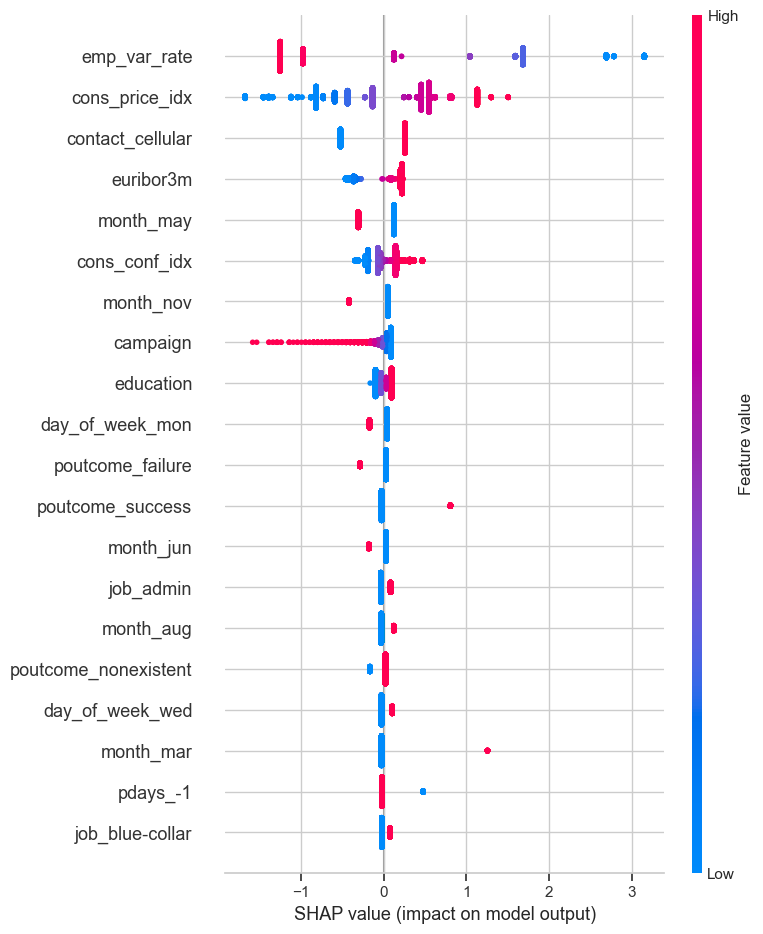

In [123]:
shap.summary_plot(shap_values, test_shap, feature_names=columns)

<BarContainer object of 50 artists>

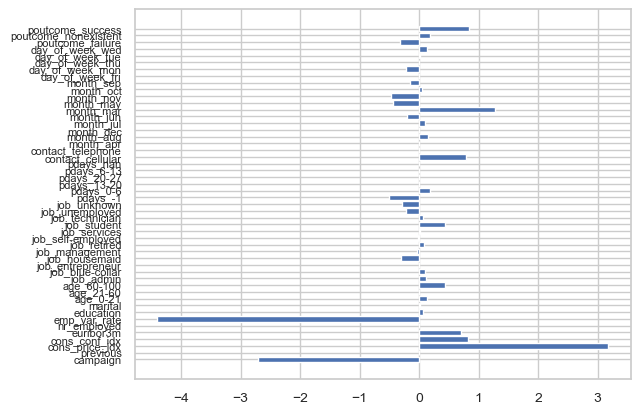

In [126]:
importances_lgr = model_lgr3[2].coef_[0]
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=8)
plt.barh(columns, importances_lgr)

In [128]:
feature_importances=pd.DataFrame(importances_lgr, columns)
feature_importances.sort_values(by=0, ascending=False)

,0
cons_price_idx,3.180197
month_mar,1.280706
poutcome_success,0.832136
cons_conf_idx,0.815363
contact_cellular,0.780507
euribor3m,0.696314
age_60-100,0.436604
job_student,0.434098
poutcome_nonexistent,0.187784
pdays_0-6,0.184686


# Tree based-model

## Decision Tree

### balanced

In [75]:
model_dt = Pipeline(steps=
                     [('preprocessor', preprocessor),
                      ('dt', DecisionTreeClassifier(class_weight = 'balanced', random_state = 0)
                      )]
                    )
model_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fd5e10ca280>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('dt',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=0))])

In [76]:
y_train_pred_dt = model_dt.predict(X_train)
y_test_pred_dt = model_dt.predict(X_test)

In [78]:
print(classification_report(y_train, y_train_pred_dt))
print(classification_report(y_test, y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     29229
           1       0.60      0.96      0.74      3711

    accuracy                           0.92     32940
   macro avg       0.79      0.94      0.84     32940
weighted avg       0.95      0.92      0.93     32940

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      7308
           1       0.25      0.38      0.30       928

    accuracy                           0.81      8236
   macro avg       0.58      0.62      0.59      8236
weighted avg       0.84      0.81      0.82      8236



In [79]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, model_dt.predict_proba(X_train)[:, 1])), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, model_dt.predict_proba(X_test)[:, 1])))

Train roc auc score:  0.988 
Test roc auc score 0.618


### smote

In [80]:
model_dt1 = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm',SMOTE()),
                      ('dt', DecisionTreeClassifier(random_state = 0)
                      )]
                    )
model_dt1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fd5e10ca280>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('sm', SMOTE()),
                ('dt', DecisionTreeClassifier(random_state=0))])

In [81]:
y_train_pred_dt1 = model_dt1.predict(X_train)
y_test_pred_dt1 = model_dt1.predict(X_test)

In [82]:
print(classification_report(y_train, y_train_pred_dt1))
print(classification_report(y_test, y_test_pred_dt1))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29229
           1       0.90      0.73      0.81      3711

    accuracy                           0.96     32940
   macro avg       0.93      0.86      0.89     32940
weighted avg       0.96      0.96      0.96     32940

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      7308
           1       0.39      0.34      0.36       928

    accuracy                           0.87      8236
   macro avg       0.65      0.63      0.64      8236
weighted avg       0.86      0.87      0.86      8236



In [83]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, model_dt1.predict_proba(X_train)[:, 1])), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, model_dt1.predict_proba(X_test)[:, 1])))

Train roc auc score:  0.987 
Test roc auc score 0.633


### Hyperparameter tunning

In [84]:
model_dt = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('dt', DecisionTreeClassifier(random_state=0))]
                    )

dt_param_grid =  {"dt__criterion":['gini', 'entropy'],
                  "dt__max_depth":range(1, 10),
                  "dt__min_samples_split":range(2, 10),
                  "dt__min_samples_leaf":range(1, 5)}
    
rsf = StratifiedKFold(random_state=42, shuffle=True)
dt = GridSearchCV(model_dt, param_grid=dt_param_grid, cv=rsf)
               
dt.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['campaign',
                                                                          'previous',
                                                                          'cons_price_idx',
                                                                          'cons_conf_idx',
                                                                          'euribor3m',
                                                                          'nr_employed',
                                                                          'emp_var_rate']),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('ord',
                                                                                          <__main__.ordinal_T...
                                                                          'marital']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['age',
                                                                          'job',
                                                                          'pdays',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])])),
                                       ('sm', SMOTE(random_state=42)),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=0))]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': range(1, 10),
                         'dt__min_samples_leaf': range(1, 5),
                         'dt__min_samples_split': range(2, 10)})

In [85]:
dt.best_estimator_ 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fd5343d4220>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('sm', SMOTE(random_state=42)),
                ('dt', DecisionTreeClassifier(max_depth=1, random_state=0))])

In [383]:
dt.best_params_

{'dt__criterion': 'gini',
 'dt__max_depth': 1,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2}

In [384]:
dt.best_score_

0.8729606104694815

#### tunned result

In [39]:
model_dtf = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('dt', DecisionTreeClassifier(random_state=0, criterion='gini',
                                                    max_depth=1, min_samples_leaf=1, min_samples_split=2))]
                    )


model_dtf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fddb7e4b400>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('sm', SMOTE(random_state=42)),
                ('dt', DecisionTreeClassifier(max_depth=1, random_state=0))])

In [40]:
y_train_pred_dtf = model_dtf.predict(X_train)
y_test_pred_dtf = model_dtf.predict(X_test)

In [41]:
print(classification_report(y_train, y_train_pred_dtf))
print(classification_report(y_test, y_test_pred_dtf))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     29229
           1       0.44      0.48      0.46      3711

    accuracy                           0.87     32940
   macro avg       0.69      0.70      0.69     32940
weighted avg       0.88      0.87      0.88     32940

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7308
           1       0.46      0.46      0.46       928

    accuracy                           0.88      8236
   macro avg       0.70      0.70      0.70      8236
weighted avg       0.88      0.88      0.88      8236



In [42]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, model_dtf.predict_proba(X_train)[:, 1])), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, model_dtf.predict_proba(X_test)[:, 1])))

Train roc auc score:  0.701 
Test roc auc score 0.696


<function matplotlib.pyplot.show(close=None, block=None)>

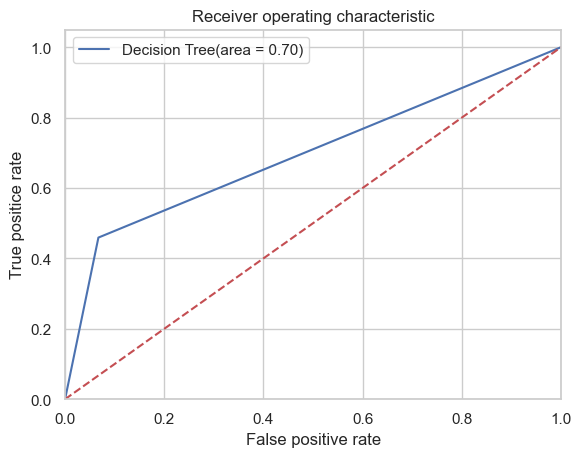

In [43]:
from sklearn.metrics import roc_curve
lr_roc_auc = roc_auc_score(y_test, model_dtf.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model_dtf.predict_proba(X_test)[:, 1], pos_label=1)

plt.figure()
plt.plot(fpr, tpr, label='Decision Tree(area = %0.2f)'%lr_roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positice rate')
plt.title('Receiver operating characteristic')
plt.legend()
plt.savefig("Loc_Roc")
plt.show

#### feature importances

<BarContainer object of 50 artists>

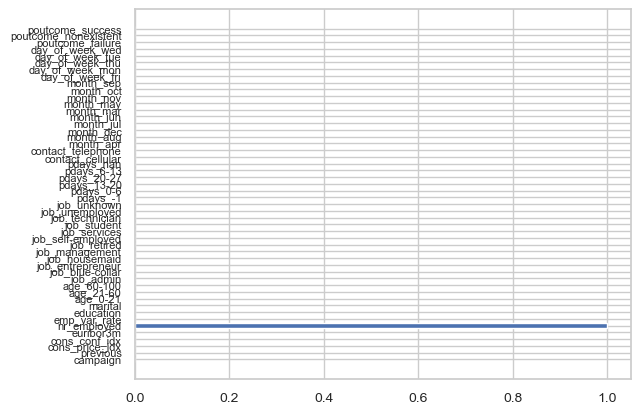

In [699]:
importances_dt = model_dtf.steps[2][1].feature_importances_
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=8)
plt.barh(columns, importances_dt)

In [701]:
pd.DataFrame(importances_dt, columns).sort_values(by =0, ascending=False)

,0
nr_employed,1.0
campaign,0.0
month_may,0.0
pdays_6-13,0.0
pdays_nan,0.0
contact_cellular,0.0
contact_telephone,0.0
month_apr,0.0
month_aug,0.0
month_dec,0.0


### RandomForest classifier

#### banlanced

In [702]:
model_rf1 = Pipeline(steps=
                     [('preprocessor', preprocessor),
                      ('rf', RandomForestClassifier(class_weight = 'balanced', random_state = 0)
                      )]
                    )
model_rf1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7f77c00f2e50>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])

In [703]:
y_train_pred_rf1 = model_rf1.predict(X_train)
y_test_pred_rf1 = model_rf1.predict(X_test)

In [704]:
print(classification_report(y_train, y_train_pred_rf1))
print(classification_report(y_test, y_test_pred_rf1))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     29234
           1       0.70      0.90      0.79      3711

    accuracy                           0.95     32945
   macro avg       0.84      0.93      0.88     32945
weighted avg       0.95      0.95      0.95     32945

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      7309
           1       0.36      0.33      0.35       928

    accuracy                           0.86      8237
   macro avg       0.64      0.63      0.63      8237
weighted avg       0.85      0.86      0.86      8237



In [705]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, model_rf1.predict_proba(X_train)[:, 1])), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, model_rf1.predict_proba(X_test)[:, 1])))

Train roc auc score:  0.984 
Test roc auc score 0.733


#### smote

In [706]:
model_rf2 = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('rf', RandomForestClassifier(random_state = 0)
                      )]
                    )

model_rf2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7f77c00f2e50>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('sm', SMOTE(random_state=42)),
                ('rf', RandomForestClassifier(random_state=0))])

In [707]:
y_train_pred_rf2 = model_rf2.predict(X_train)
y_test_pred_rf2 = model_rf2.predict(X_test)

In [708]:
print(classification_report(y_train, y_train_pred_rf2))
print(classification_report(y_test, y_test_pred_rf2))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     29234
           1       0.87      0.77      0.82      3711

    accuracy                           0.96     32945
   macro avg       0.92      0.88      0.90     32945
weighted avg       0.96      0.96      0.96     32945

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7309
           1       0.44      0.35      0.39       928

    accuracy                           0.88      8237
   macro avg       0.68      0.65      0.66      8237
weighted avg       0.87      0.88      0.87      8237



In [713]:
model_rf2.score(X_train, y_train_pred_rf2)#accuracy

1.0

In [714]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, model_rf2.predict_proba(X_train)[:, 1])), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, model_rf2.predict_proba(X_test)[:, 1])))

Train roc auc score:  0.980 
Test roc auc score 0.757


<BarContainer object of 50 artists>

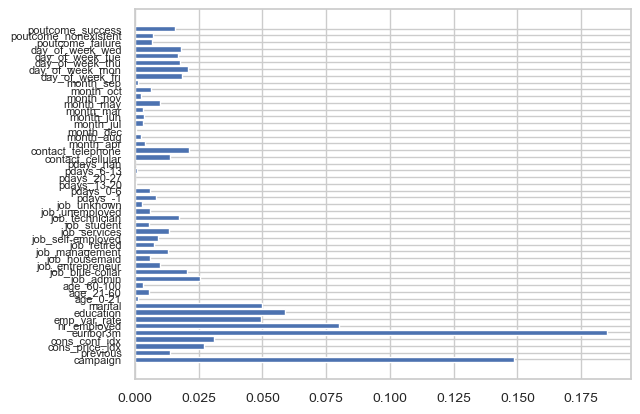

In [715]:
importances_rf2 = model_rf2.steps[2][1].feature_importances_
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=8)
plt.barh(columns, importances_rf2)

In [716]:
pd.DataFrame(importances_rf2, columns).sort_values(by = 0, ascending=False)

,0
euribor3m,0.185210
campaign,0.148557
nr_employed,0.080077
education,0.058922
marital,0.049843
emp_var_rate,0.049440
cons_conf_idx,0.031023
cons_price_idx,0.026946
job_admin,0.025578
contact_telephone,0.021238


#### hypaparameter tunning

In [675]:
model_rf = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('rf', RandomForestClassifier(random_state=0))]
                    )

rf_param_grid =  {'rf__n_estimators': [300,400,500,600],
                  'rf__criterion': ['gini', 'entropy'],
                  'rf__max_depth': [7,10,15,20],
                  'rf__min_samples_leaf': [1,2,4],
                  'rf__max_features': ['auto', 'log2']}
    
rsf = StratifiedKFold(random_state=42, shuffle=True)
rf = GridSearchCV(model_rf,param_grid=rf_param_grid,
                     n_jobs=4, cv=rsf)
               
rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['campaign',
                                                                          'previous',
                                                                          'cons_price_idx',
                                                                          'cons_conf_idx',
                                                                          'euribor3m',
                                                                          'nr_employed',
                                                                          'emp_var_rate']),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('ord',
                                                                                          <__main__.ordinal_Transformer object at 0x7f77c00f2e50>)]),
                                                                         ['education',
                                                                          'mari...
                                                                                          OneHotEncoder())]),
                                                                         ['age',
                                                                          'job',
                                                                          'pdays',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])])),
                                       ('sm', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=4,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [7, 10, 15, 20],
                         'rf__max_features': ['auto', 'log2'],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__n_estimators': [300, 400, 500, 600]})

In [676]:
rf.best_estimator_, rf.best_params_, rf.best_score_

(Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('scaler',
                                                                    MinMaxScaler())]),
                                                   ['campaign', 'previous',
                                                    'cons_price_idx',
                                                    'cons_conf_idx', 'euribor3m',
                                                    'nr_employed',
                                                    'emp_var_rate']),
                                                  ('ordinal',
                                                   Pipeline(steps=[('ord',
                                                                    <__main__.ordinal_Transformer object at 0x7f77c641f580>)]),
                                                   ['education', 'marital']),
                                   

#### tunned result

In [35]:
model_rft = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('rf', RandomForestClassifier(random_state=0, criterion='entropy', n_estimators = 300,
                                                    max_depth=20, max_features='auto', min_samples_leaf=2))]
                    )
               
model_rft.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x00000242F3C19C40>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('sm', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=20,
                                        min_samples_leaf=2, n_estimators=300,
                                        random_state=0))])

In [45]:
y_train_pred_rft = model_rft.predict(X_train)
y_test_pred_rft = model_rft.predict(X_test)

In [46]:
print(classification_report(y_train, y_train_pred_rft))
print(classification_report(y_test, y_test_pred_rft))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     29229
           1       0.65      0.61      0.63      3711

    accuracy                           0.92     32940
   macro avg       0.80      0.78      0.79     32940
weighted avg       0.92      0.92      0.92     32940

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      7308
           1       0.51      0.46      0.49       928

    accuracy                           0.89      8236
   macro avg       0.72      0.70      0.71      8236
weighted avg       0.89      0.89      0.89      8236



In [47]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, y_train_pred_rft)), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, y_test_pred_rft)))

Train roc auc score:  0.783 
Test roc auc score 0.703


<function matplotlib.pyplot.show(close=None, block=None)>

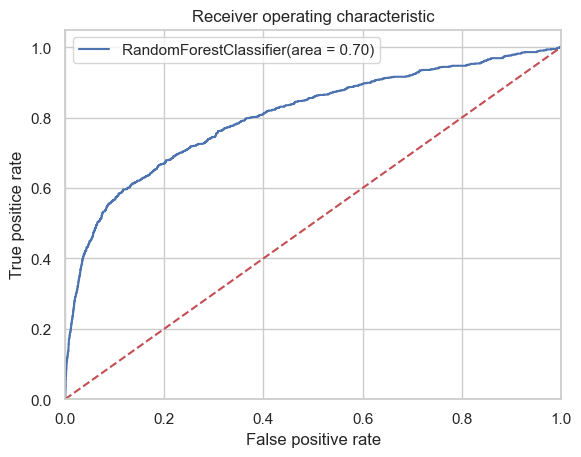

In [48]:
from sklearn.metrics import roc_curve
lr_roc_auc = roc_auc_score(y_test, model_rft.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model_rft.predict_proba(X_test)[:, 1], pos_label=1)

plt.figure()
plt.plot(fpr, tpr, label='RandomForestClassifier(area = %0.2f)'%lr_roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positice rate')
plt.title('Receiver operating characteristic')
plt.legend()
plt.savefig("Loc_Roc")
plt.show

#### RF-feature importances

<BarContainer object of 50 artists>

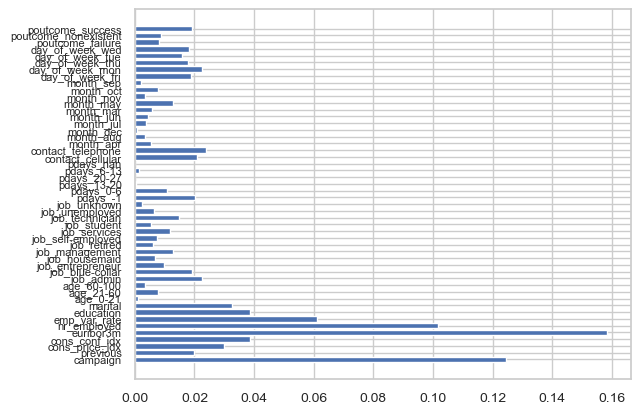

In [49]:
importances_rft = model_rft.steps[2][1].feature_importances_
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=8)
plt.barh(columns, importances_rft)

In [50]:
import shap

#load JS vis in the notebook
shap.initjs() 

#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(model_rft[2])

#apply the preprocessing to x_test
observations = model_rft[0].transform(X_test)

#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

#plot the feature importance
#shap.summary_plot(shap_values, plot_type="bar")

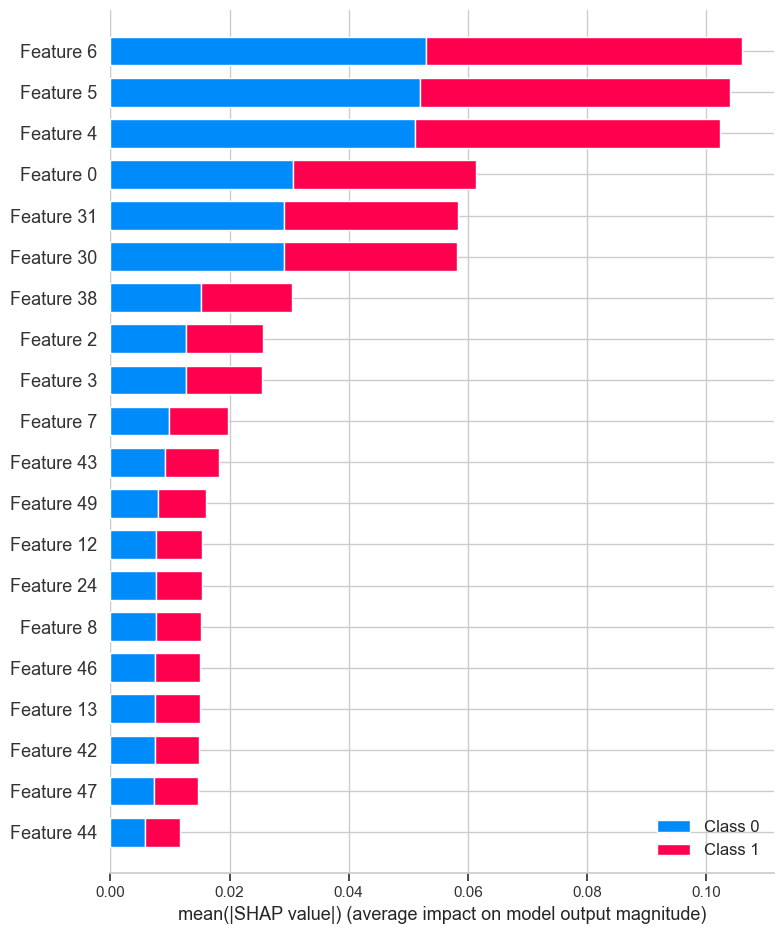

In [52]:
shap.summary_plot(shap_values, plot_type="bar")

### GBM gradient boosting classifier


#### smote

In [ ]:
model_gbc = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('gbc', GradientBoostingClassifier(random_state = 0)
                      )]
                    )

model_gbc.fit(X_train, y_train)

In [ ]:
y_train_pred_gbc = model_gbc.predict(X_train)
y_test_pred_gbc = model_gbc.predict(X_test)

In [ ]:
print(classification_report(y_train, y_train_pred_gbc))
print(classification_report(y_test, y_test_pred_gbc))

In [ ]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, y_train_pred_gbc)), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, y_test_pred_gbc)))

#### hymperparameter tunning
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [619]:
#determine the learning rate. default 0.1, if n-estmiator<=20, should decrease; if ~100, should decrease.
model_hgb2 = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('gbc', GradientBoostingClassifier(random_state=0,learning_rate = 0.1, 
                      min_samples_split=500, min_samples_leaf=50,max_depth=8,
                      max_features='sqrt',subsample=0.8))]
                    )

gbc_param_grid =  {'gbc__n_estimators': range(20,81,10)}
rsf = StratifiedKFold(random_state=42, shuffle=True)
tuning = GridSearchCV(model_hgb2,param_grid=gbc_param_grid,
                     scoring='roc_auc',n_jobs=4, cv=rsf)
               
tuning.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['campaign',
                                                                          'previous',
                                                                          'cons_price_idx',
                                                                          'cons_conf_idx',
                                                                          'euribor3m',
                                                                          'nr_employed',
                                                                          'emp_var_rate']),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('ord',
                                                                                          <__main__.ordinal_Transformer object at 0x7f7887345dc0>)]),
                                                                         ['education',
                                                                          'mari...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['age',
                                                                          'job',
                                                                          'pdays',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])])),
                                       ('sm', SMOTE(random_state=42)),
                                       ('gbc',
                                        GradientBoostingClassifier(max_depth=8,
                                                                   max_features='sqrt',
                                                                   min_samples_leaf=50,
                                                                   min_samples_split=500,
                                                                   random_state=0,
                                                                   subsample=0.8))]),
             n_jobs=4, param_grid={'gbc__n_estimators': range(20, 81, 10)},
             scoring='roc_auc')

In [620]:
tuning.best_params_, tuning.best_score_ #will decrease learning_rate

({'gbc__n_estimators': 30}, 0.7928130321148098)

In [120]:
tuning.best_params_, tuning.best_score_

({'gbc__learning_rate': 0.05, 'gbc__n_estimators': 30}, 0.7928623804683144)

#### tunned result

In [54]:
model_gbm = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('gbc', GradientBoostingClassifier(learning_rate=0.05, random_state=0, 
                      min_samples_split=600, n_estimators=30,max_features='sqrt',
                    min_samples_leaf=60,max_depth=37,subsample=0.8))]
                    )
              
model_gbm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fddb7e4b400>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['age', 'job', 'pdays',
                                                   'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('sm', SMOTE(random_state=42)),
                ('gbc',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=37,
                                            max_features='sqrt',
                                            min_samples_leaf=60,
                                            min_samples_split=600,
                                            n_estimators=30, random_state=0,
                                            subsample=0.8))])

In [55]:
y_train_pred_gbm = model_gbm.predict(X_train)
y_test_pred_gbm = model_gbm.predict(X_test)
print(classification_report(y_train, y_train_pred_gbm))
print(classification_report(y_test, y_test_pred_gbm))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     29229
           1       0.44      0.60      0.50      3711

    accuracy                           0.87     32940
   macro avg       0.69      0.75      0.71     32940
weighted avg       0.89      0.87      0.88     32940

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7308
           1       0.46      0.59      0.52       928

    accuracy                           0.88      8236
   macro avg       0.70      0.75      0.72      8236
weighted avg       0.89      0.88      0.88      8236



In [56]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, y_train_pred_gbm)), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, y_test_pred_gbm)))

Train roc auc score:  0.749 
Test roc auc score 0.749


In [94]:
# shap values 
shap.initjs()
model_gbm.fit(X_train, y_train)
X_shap = model_gbm[0].fit_transform(X_train)
test_shap  = model_gbm[0].transform(X_test)
explainer = shap.TreeExplainer(model_gbm.named_steps['gbc'], X_shap, feature_perturbation="interventional")
shap_values = explainer.shap_values(test_shap)

100%|===================| 8221/8236 [00:35<00:00]        

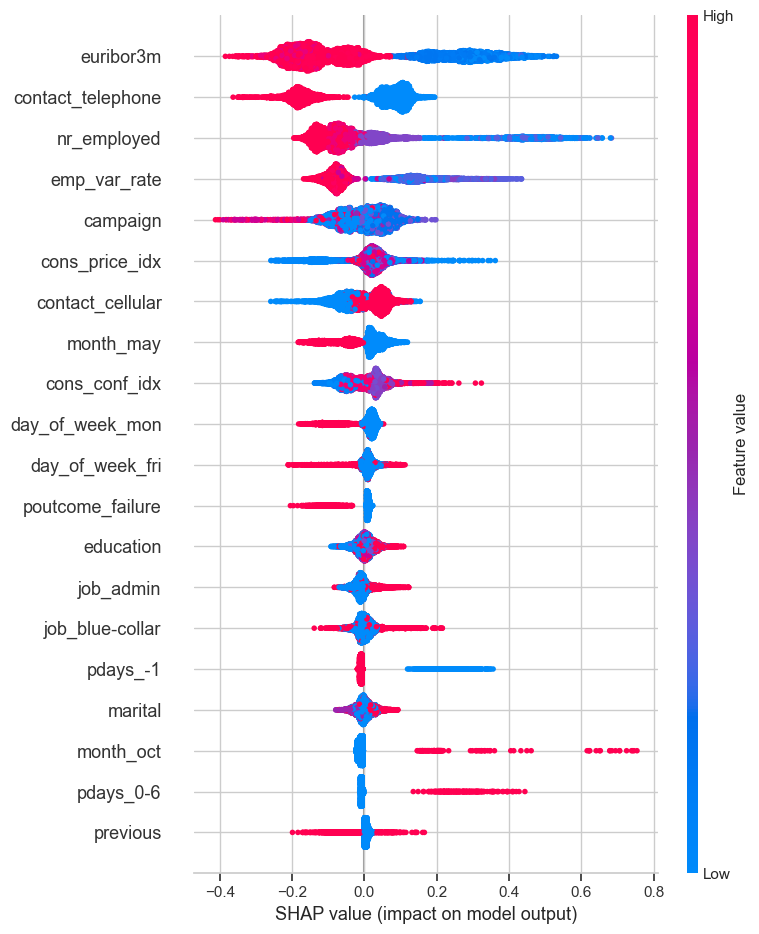

In [95]:
shap.summary_plot(shap_values, test_shap, feature_names=columns)

In [75]:
# shap values bar figure
shap.initjs()
explainer = shap.TreeExplainer(model_gbm[2])
observations = model_gbm[0].transform(X_test)
shap_values = explainer.shap_values(observations)

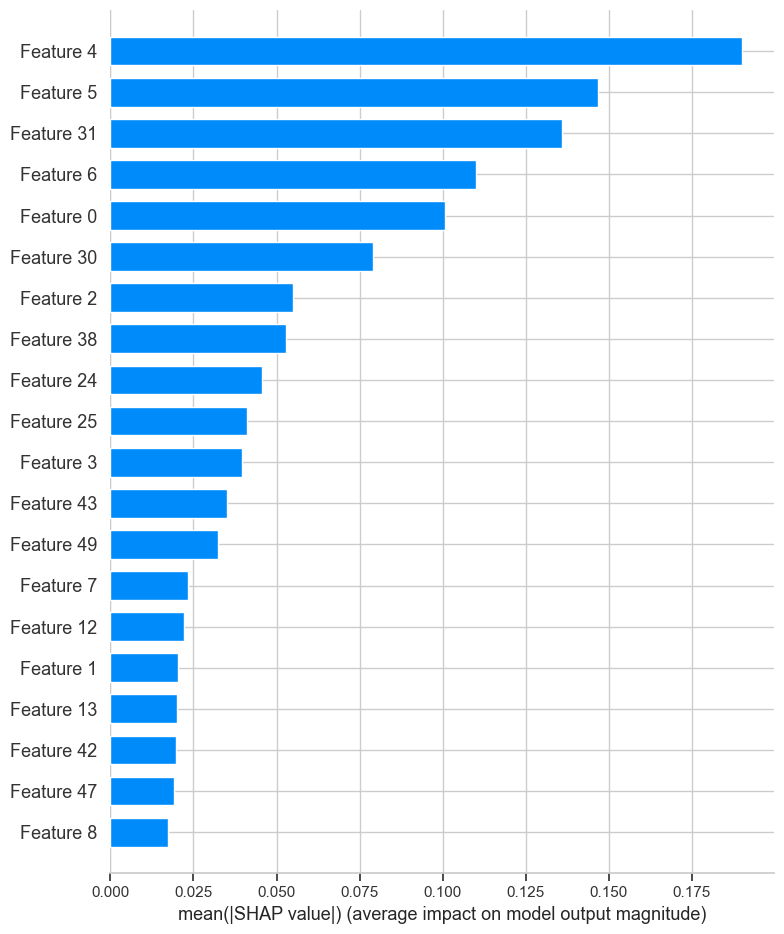

In [76]:
shap.summary_plot(shap_values, plot_type="bar")

[[26390  2839]
 [ 1501  2210]]


<AxesSubplot:>

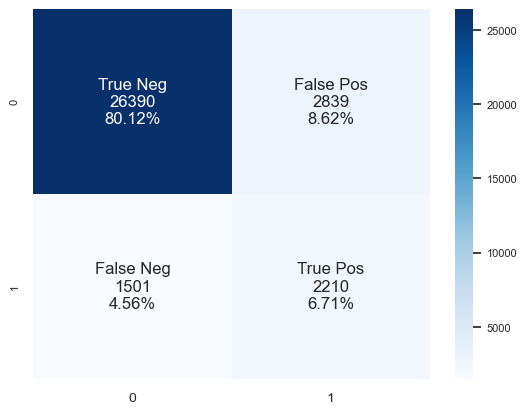

In [96]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_train, y_train_pred_gbm)
print(cf_matrix)

import seaborn as sns
import numpy as np
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

[[6674  634]
 [ 385  543]]


<AxesSubplot:>

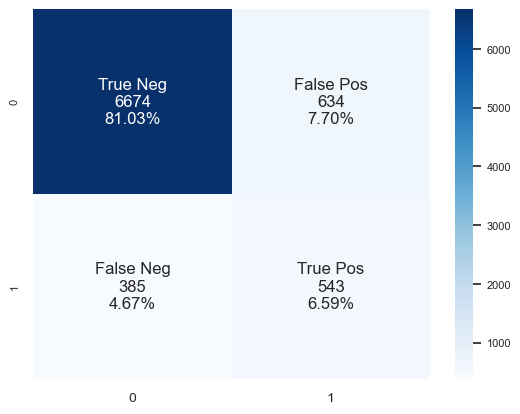

In [100]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_test_pred_gbm)
print(cf_matrix)

import seaborn as sns
import numpy as np
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [11]:
4/6


0.6666666666666666

In [9]:
3000*52


156000

In [12]:
3/5


0.6

In [13]:
0.66/0.6

1.1

In [16]:
1/0.6

1.6666666666666667

<function matplotlib.pyplot.show(close=None, block=None)>

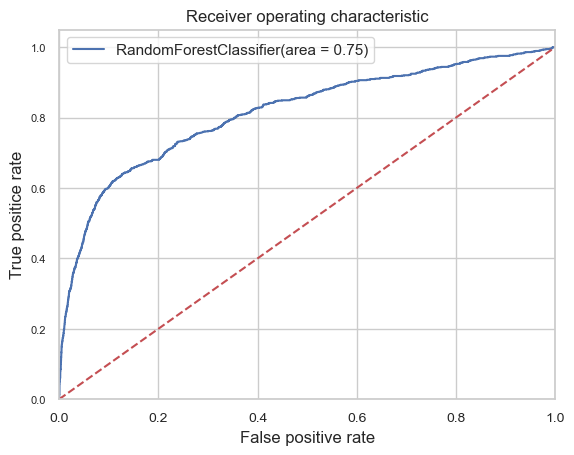

In [97]:
from sklearn.metrics import roc_curve
lr_roc_auc = roc_auc_score(y_test, model_gbm.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model_gbm.predict_proba(X_test)[:, 1], pos_label=1)

plt.figure()
plt.plot(fpr, tpr, label='RandomForestClassifier(area = %0.2f)'%lr_roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positice rate')
plt.title('Receiver operating characteristic')
plt.legend()
plt.savefig("Loc_Roc")
plt.show

### XGBClassifier

#### smote

In [115]:
import xgboost as xgb

model_xgbc = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE()),
                      ('xgb', xgb.XGBClassifier(random_state = 0)
                      )]
                    )
model_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7f9805b5cdf0>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [727]:
y_train_pred_xgbc = model_xgbc.predict(X_train)
y_test_pred_xgbc = model_xgbc.predict(X_test)

In [728]:
print(classification_report(y_train, y_train_pred_xgbc))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     29234
           1       0.71      0.45      0.55      3711

    accuracy                           0.92     32945
   macro avg       0.82      0.71      0.75     32945
weighted avg       0.91      0.92      0.91     32945



In [729]:
print(classification_report(y_test, y_test_pred_xgbc))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7309
           1       0.57      0.33      0.42       928

    accuracy                           0.90      8237
   macro avg       0.75      0.65      0.68      8237
weighted avg       0.88      0.90      0.88      8237



In [730]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, y_train_pred_xgbc)), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, y_test_pred_xgbc)))

Train roc auc score:  0.714 
Test roc auc score 0.648


#### hyperparameter tunning

In [71]:
model_xgbc = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('xgbc', xgb.XGBClassifier(random_state = 0))]
                    )

xgbc_param_grid =  {'xgbc__learning_rate': [0.01, 0.05, 0.1]}
    
rsf = StratifiedKFold(random_state=42, shuffle=True)
tuning = GridSearchCV(model_xgbc,param_grid=xgbc_param_grid,
                     scoring='roc_auc',n_jobs=4, cv=rsf)
               
tuning.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['campaign',
                                                                          'previous',
                                                                          'cons_price_idx',
                                                                          'cons_conf_idx',
                                                                          'euribor3m',
                                                                          'nr_employed',
                                                                          'emp_var_rate']),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('ord',
                                                                                          <__main__.ordinal_T...
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=0, ...))]),
             n_jobs=4, param_grid={'xgbc__learning_rate': [0.01, 0.05, 0.1]},
             scoring='roc_auc')

In [35]:
model_xgbc = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('xgbc', xgb.XGBClassifier(random_state = 0, learning_rate = 0.05))]
                    )

xgbc_param_grid =  {'xgbc__n_estimators': [50,100, 200],
                    'xgbc__max_depth': [1, 3, 5],
                    'xgbc__subsample': np.arange(0.5, 1.0, 0.1)
                    }
    
rsf = StratifiedKFold(random_state=42, shuffle=True)
tuning = GridSearchCV(model_xgbc,param_grid=xgbc_param_grid,
                     scoring='roc_auc',n_jobs=4, cv=rsf)
               
tuning.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['campaign',
                                                                          'previous',
                                                                          'cons_price_idx',
                                                                          'cons_conf_idx',
                                                                          'euribor3m',
                                                                          'nr_employed',
                                                                          'emp_var_rate']),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('ord',
                                                                                          <__main__.ordinal_T...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=0, ...))]),
             n_jobs=4,
             param_grid={'xgbc__max_depth': [1, 3, 5],
                         'xgbc__n_estimators': [50, 100, 200],
                         'xgbc__subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
             scoring='roc_auc')

In [36]:
tuning.best_params_, tuning.best_score_ 

({'xgbc__max_depth': 5, 'xgbc__n_estimators': 50, 'xgbc__subsample': 0.6},
 0.7898468536547849)

In [38]:
model_xgbc = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('xgbc', xgb.XGBClassifier(random_state = 0, learning_rate = 0.05, 
                                                 n_estimators=50, subsample=0.6))]
                    )

xgbc_param_grid =  {'xgbc__max_depth': [5, 20, 50],
                    'xgbc__colsample_bytree': np.arange(0.5, 1.0, 0.1),
                    'xgbc__colsample_bylevel': np.arange(0.5, 1.0, 0.1)
                   }
    
rsf = StratifiedKFold(random_state=42, shuffle=True)
tuning = GridSearchCV(model_xgbc,param_grid=xgbc_param_grid,
                     scoring='roc_auc',n_jobs=4, cv=rsf)
               
tuning.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['campaign',
                                                                          'previous',
                                                                          'cons_price_idx',
                                                                          'cons_conf_idx',
                                                                          'euribor3m',
                                                                          'nr_employed',
                                                                          'emp_var_rate']),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('ord',
                                                                                          <__main__.ordinal_T...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=50,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=0, ...))]),
             n_jobs=4,
             param_grid={'xgbc__colsample_bylevel': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                         'xgbc__colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                         'xgbc__max_depth': [5, 20, 50]},
             scoring='roc_auc')

In [39]:
tuning.best_params_, tuning.best_score_ 

({'xgbc__colsample_bylevel': 0.8999999999999999,
  'xgbc__colsample_bytree': 0.5,
  'xgbc__max_depth': 5},
 0.7915644867111584)

#### tunned result

In [112]:
model_xgbc1 = imbPipeline(steps=
                     [('preprocessor', preprocessor),
                      ('sm', SMOTE(random_state = 42)),
                      ('gbc', xgb.XGBClassifier(learning_rate=0.05, random_state=0, 
                        subsample = 0.6, n_estimators=50, max_depth=5, colsample_bytree= 0.5,
                       colsample_bylevel=0.9))]
                    )
model_xgbc1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['campaign', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed',
                                                   'emp_var_rate']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ord',
                                                                   <__main__.ordinal_Transformer object at 0x7fddb7e4b400>)]),
                                                  ['education', 'marital']),
                                                 ('cat',
                                                  Pipeline(steps...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.05,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=50, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, ...))])

In [44]:
y_train_pred_xgbc1 = model_xgbc1.predict(X_train)
y_test_pred_xgbc1 = model_xgbc1.predict(X_test)

In [45]:
print(classification_report(y_train, y_train_pred_xgbc1))
print(classification_report(y_test, y_test_pred_xgbc1))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     29229
           1       0.44      0.58      0.50      3711

    accuracy                           0.87     32940
   macro avg       0.69      0.74      0.71     32940
weighted avg       0.89      0.87      0.88     32940

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7308
           1       0.47      0.57      0.51       928

    accuracy                           0.88      8236
   macro avg       0.71      0.74      0.72      8236
weighted avg       0.89      0.88      0.88      8236



In [46]:
from sklearn.metrics import roc_auc_score
print('Train roc auc score: {0: .3f}'.format(roc_auc_score(y_train, y_train_pred_xgbc1)), '\n'
      'Test roc auc score{0: .3f}'.format(roc_auc_score(y_test, y_test_pred_xgbc1)))

Train roc auc score:  0.743 
Test roc auc score 0.743


In [53]:
explainer = shap.TreeExplainer(model_xgbc1[2])

In [66]:
shap.initjs() 
explainer = shap.TreeExplainer(model_xgbc1[2])
observations = model_xgbc1[0].transform(X_test)
shap_values = explainer.shap_values(observations)

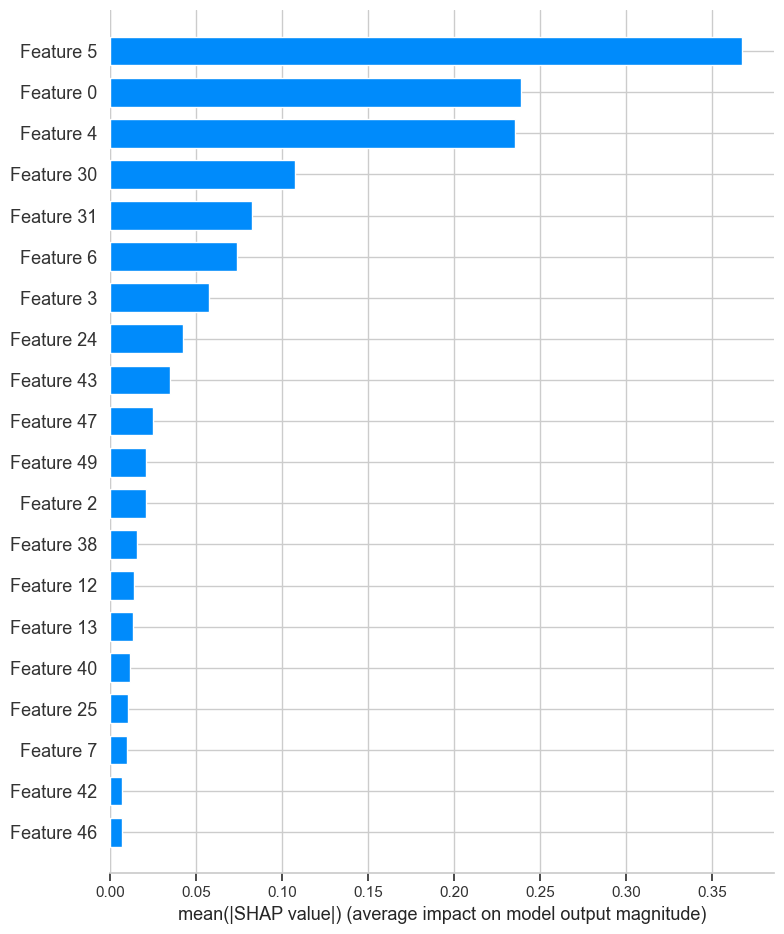

In [70]:
shap.summary_plot(shap_values,plot_type="bar")

# post 

In [3]:
data = {'train ROC_AUC':[0.792, 0.701, 0.783, 0.749, 0.743],
        'test ROC_AUC':[0.802, 0.696, 0.703, 0.749, 0.743],
        'train precision':[0.33, 0.44, 0.65, 0.44, 0.44],
        'test precision': [0.35, 0.46, 0.51, 0.46, 0.47],
        'train recall':[0.63,0.48, 0.61, 0.60, 0.58],
        'test recall': [0.64,0.46, 0.46, 0.59, 0.57],
        'train f1 score':[0.44,0.46, 0.63, 0.50, 0.50],
        'test f1 score': [0.46,0.46, 0.49, 0.52, 0.51],
       }
pd.DataFrame(data, index=['lg', 'dt', 'rf', 'gbc','xgbc'])

,train ROC_AUC,test ROC_AUC,train precision,test precision,train recall,test recall,train f1 score,test f1 score
lg,0.792,0.802,0.33,0.35,0.63,0.64,0.44,0.46
dt,0.701,0.696,0.44,0.46,0.48,0.46,0.46,0.46
rf,0.783,0.703,0.65,0.51,0.61,0.46,0.63,0.49
gbc,0.749,0.749,0.44,0.46,0.60,0.59,0.50,0.52
xgbc,0.743,0.743,0.44,0.47,0.58,0.57,0.50,0.51


Final model: Gradient Boosting Calssifier

- euribor3m (negative)
- cotact_telephone(negative)
- nr_employed(positive)
- emp_var_rate(positive)
- campaign(negative)
- Monday and Friday are not good to reach out customer
- poutcome_failure, negative contributer
- Month: May and Oct has better winning posibility
- job: admin and blue-collar seems to have higher impact

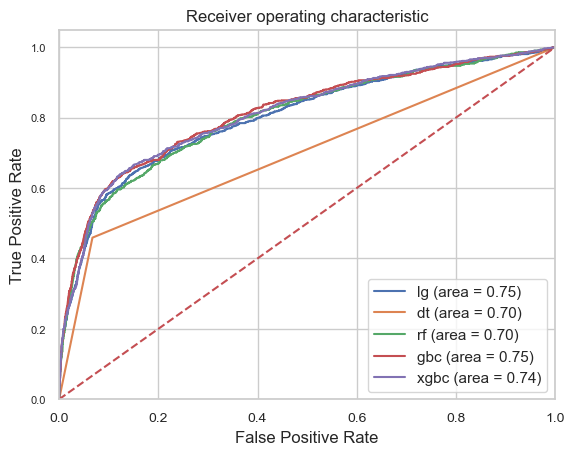

In [113]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

lg_roc_auc = roc_auc_score(y_test, model_lgr3.predict(X_test))
fprlg, tprlg, thresholdslg = roc_curve(y_test, model_lgr3.predict_proba(X_test)[:,1])

dt_roc_auc = roc_auc_score(y_test, model_dtf.predict(X_test))
fprdt, tprdt, thresholdsdt = roc_curve(y_test, model_dtf.predict_proba(X_test)[:,1])

rf_roc_auc = roc_auc_score(y_test, model_rft.predict(X_test))
fprrf, tprrf, thresholds_rf = roc_curve(y_test, model_rft.predict_proba(X_test)[:,1])

gbc_roc_auc = roc_auc_score(y_test, model_gbm.predict(X_test))
fprgbc, tprgbc, thresholds_gbc = roc_curve(y_test, model_gbm.predict_proba(X_test)[:,1])

xgbc_roc_auc = roc_auc_score(y_test, model_xgbc1.predict(X_test))
fprxgbc, tprxgbc, thresholds_xgbc = roc_curve(y_test, model_xgbc1.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fprlg, tprlg, label='lg (area = %0.2f)' % lg_roc_auc)
plt.plot(fprdt, tprdt, label='dt (area = %0.2f)' % dt_roc_auc)
plt.plot(fprrf, tprrf, label='rf (area = %0.2f)' % rf_roc_auc)
plt.plot(fprgbc, tprgbc, label='gbc (area = %0.2f)' % gbc_roc_auc)
plt.plot(fprxgbc, tprxgbc, label='xgbc (area = %0.2f)' % xgbc_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()